In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.chdir('..')
from notebooks import config
import geopandas as gpd
import numpy as np
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from osgeo import gdal
import subprocess
from glob import glob


In [3]:
# path_vector = 'I:/tibet-water/tibet_tiles.gpkg'
path_vector = config.root_proj +  '/data/tibet/tibet_tiles_vec/tibet_tiles.gpkg'     # luo's computer
tiles_gdf = gpd.read_file(path_vector)
tiles_gdf.head()

,area,proj,tile_id,geometry
0,10852.910371,EPSG: 32646,001,"MULTIPOLYGON (((91.60292 25.97742, 91.60292 26..."
1,10856.066053,EPSG: 32646,002,"MULTIPOLYGON (((92.59904 25.97742, 92.59904 26..."
2,10853.222782,EPSG: 32647,003,"MULTIPOLYGON (((97.64819 25.97742, 97.64819 26..."
3,10856.025776,EPSG: 32647,004,"MULTIPOLYGON (((98.64468 25.97742, 98.64468 26..."
4,10850.995157,EPSG: 32647,005,"MULTIPOLYGON (((99.64905 25.97742, 99.64905 26..."


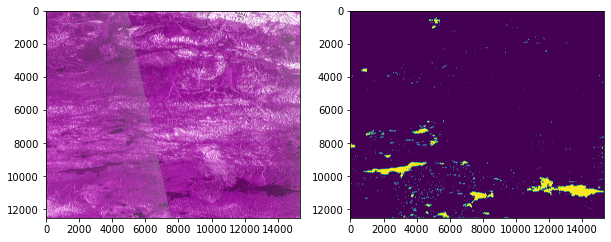

In [4]:
# ## check the prediction water map
# ## -- data path
tile_id = '239'
path_s1_img = config.root_tb_data + '/tibet-202008/s1_ascend/tibet_s1as_202008_tile_' + tile_id + '.tif'
# path_wat = config.root_tb_data + '/tibet-202008/s1_water_tmp/tibet_s1_202008_tile_' + tile_id + '_water.tif'
path_wat = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water.tif' # luo's computer

## -- data read
s1_img_tile, s1_img_tile_info = readTiff(path_in = path_s1_img)
s1_tile_wat, s1_tile_wat_info = readTiff(path_in = path_wat)
## -- data visualization
plt.figure(figsize=(10,5))
## plot s1 image
plt.subplot(1,2,1)
imgShow(s1_img_tile, color_bands=(0,1,0), clip_percent=2)
## plot water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, color_bands=(0,1,0), clip_percent=2)



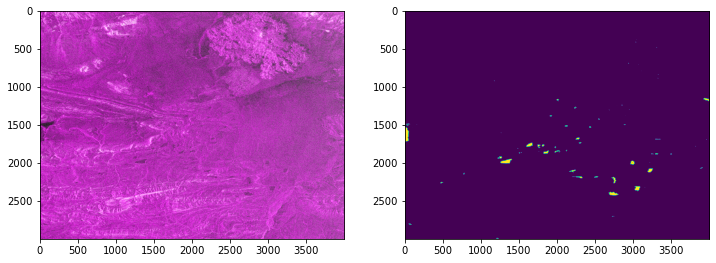

In [5]:
plt.figure(figsize=(12,8))
region = [2000,5000,1000,5000]
plt.subplot(1,2,1)
imgShow(s1_img_tile, color_bands=(0,1,0), clip_percent=2, focus=region)
## plot water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, color_bands=(0,1,0), clip_percent=2, focus=region)


## Remove the buffer region of the tile image

In [ ]:
# tile_id = '201'
for id in range(200,201):
    tile_id = str(id+1).rjust(3,'0')
    print('tile_'+tile_id)
    # path_wat = config.root_tb_data + '/tibet-202008/s1_water_1/tibet_s1_202008_tile_' + tile_id + '_water.tif'
    # path_wat_subs = config.root_tb_data + '/tibet-202008/s1_water_1/tibet_s1_202008_tile_' + tile_id + '_water_subs.tif'
    path_wat = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water.tif'  # luo's ..
    path_wat_subs = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water_subs.tif' # luo's ..
    img, img_info = readTiff(path_in=path_wat)
    idx, = np.where(tiles_gdf['tile_id'].values == tile_id)
    tile_region = tiles_gdf.loc[int(idx)]['geometry'].bounds
    left_up = [tile_region[0],tile_region[3]]
    right_down = [tile_region[2],tile_region[1]]
    extent = str(left_up[0])+' '+str(left_up[1])+' '+str(right_down[0])+' '+str(right_down[1]) 
    !gdal_translate -projwin $extent $path_wat $path_wat_subs
    ## optional for running gdal_translate script
    # command = 'gdal_translate -projwin ' + extent +  ' ' + path_wat + ' ' + path_wat_subs
    # print(os.popen(command).read())


tile_201
Input file size is 14765, 12694
0...10...20...30...40...50...60...70...80...90...100 - done.


## Check subseting of the image

In [ ]:
## check
## -- data path
tile_id = '201'
path_s1_img = config.root_tb_data + '/tibet-202008/s1_ascend/tibet_s1as_202008_tile_' + tile_id + '.tif'
path_wat = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water_subs.tif'

## -- data read
s1_img_tile, s1_img_tile_info = readTiff(path_in = path_s1_img)
s1_tile_wat, s1_tile_wat_info = readTiff(path_in = path_wat)

## -- get tile region
idx, = np.where(tiles_gdf['tile_id'].values == tile_id)
tile_region = tiles_gdf.loc[int(idx)]['geometry'].bounds


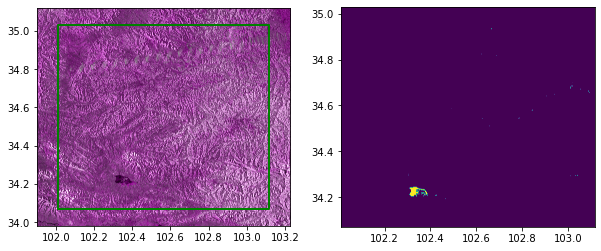

In [ ]:
plt.figure(figsize=(10,5))
## plot s1 image
plt.subplot(1,2,1)
imgShow(s1_img_tile, extent=s1_img_tile_info['geoextent'], color_bands=(0,1,0), clip_percent=2)
# outline
outline_x = [tile_region[0],tile_region[2], tile_region[2], tile_region[0],tile_region[0]]  
outline_y = [tile_region[1], tile_region[1], tile_region[3], tile_region[3], tile_region[1]]
plt.plot(outline_x, outline_y, color='g', linewidth=2)
## plot subsetted water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, extent=s1_tile_wat_info['geoextent'], color_bands=(0,1,0), clip_percent=2)



## Mosaic of the surface water maps -for windows

##Downscaling

In [19]:
# # d = Resample_batch(r"I:/s1_descend/watersub")
# dir_wat = r"I:/s1_descend/watersub"
dir_wat = config.root_tb_data + '/tibet-202008/s1_water'   # luo's computer
paths_wat = glob(dir_wat + '/*')
for path_wat in paths_wat:
  path_wat_down = path_wat.split('.')[0]+'_down.tif' 
  !gdal_translate -outsize 10% 10% -r average $path_wat $path_wat_down
  print(path_wat.split('/')[-1] + ' is downsampled successfully!')


Input file size is 13785, 12538
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_001_water.tif is downsampled successfully!
Input file size is 13873, 12461
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_002_water.tif is downsampled successfully!
Input file size is 13789, 12532
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_003_water.tif is downsampled successfully!
Input file size is 13876, 12457
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_004_water.tif is downsampled successfully!
Input file size is 13962, 12377
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_005_water.tif is downsampled successfully!
Input file size is 13990, 12454
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_006_water.tif is downsampled successfully!
Input file size is 14080, 12370
0...10...20...30...40...50

### Check downsampled data

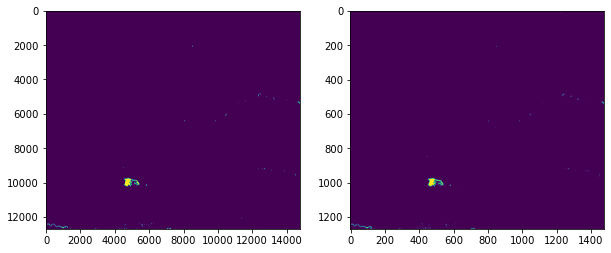

In [27]:
tile_id = 201
path_wat = config.root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + str(tile_id) + '_water.tif'
path_wat_down = paths_wat.split('.')[0] + '_down.tif'
wat_map,wat_map_info = readTiff(path_wat)
wat_map_down, wat_map_down_info = readTiff(path_wat_down)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(wat_map)
plt.subplot(1,2,2); plt.imshow(wat_map_down)


### Water maps mosaic

In [31]:
paths_wat_down = glob(config.root_tb_data + '/tibet-202008/s1_water/*_down.tif')
paths_wat_down.sort()
path_mosaic_save = config.root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic.tif'
path_mosaic_tmp = config.root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic_tmp.tif'

for i, path_wat in enumerate(paths_wat_down):
    print('merge ->', path_wat.split('/')[-1])
    if i == 0:
      !gdal_merge.py -init 0 -o $path_mosaic_save $path_wat $path_wat
      # !mv $path_mosaic_save $path_mosaic_tmp   # rename 
      os.rename(path_mosaic_save, path_mosaic_tmp)
    else:
      !gdal_merge.py -init 0 -o $path_mosaic_save $path_mosaic_tmp $path_wat
      if i < len(paths_wat_down)-1:
        # !mv $path_mosaic_save $path_mosaic_tmp  # rename
        os.rename(path_mosaic_save, path_mosaic_tmp)
# !rm $path_mosaic_tmp
os.remove(path_mosaic_tmp)



merge -> tibet_s1_202008_tile_001_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_002_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_003_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_004_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_005_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_006_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_007_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_008_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_009_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> t

### Using shapfile to clip raster dataset.

In [4]:
# input_shape = r"E:/Monthly-Surface-Water-in-Tibet-main/TB/TB.shp" 
# output_raster=r'E:/Tibet_result_clip.tif'   # Address which used for save tif
# input_raster = r"E:/Tibet_result_warp.tif"
input_shape = config.root_proj + '/data/tibet/tibet-plateau-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp' # luo's ..
input_raster = config.root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic.tif'  # luo's ..
output_raster=  config.root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic_clip.tif'  # luo's ..

input_raster=gdal.Open(input_raster)
ds = gdal.Warp(output_raster,
              input_raster,
              format = 'GTiff',
              cutlineDSName = input_shape,      
              cutlineWhere="FIELD = 'whatever'",
              dstNodata = 0)


### check mosaic and clip results.

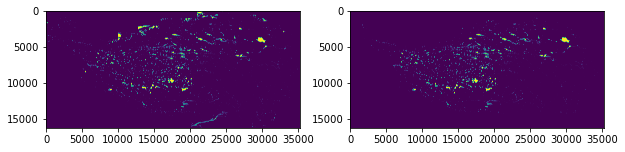

In [5]:
path_mosaic = config.root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic.tif'
path_mosaic_clip = config.root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic_clip.tif'
wat_mosaic, wat_mosaic_info = readTiff(path_mosaic)
wat_mosaic_clip, wat_mosaic_clip_info = readTiff(path_mosaic_clip)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(wat_mosaic)
plt.subplot(1,2,2)
plt.imshow(wat_mosaic_clip)


### Dispaly image using cartopy package.

35273 16257
(73.35714475342742, 0.0008986845960738538, 0.0, 40.497849638676264, 0.0, -0.0008986845960738538)


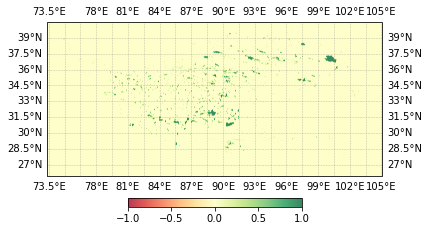

In [6]:
# path = 'E:/Tibet_result_clip.tif'
path = config.root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic_clip.tif'   # luo's ..
img_tile, img_info = readTiff(path_in = path)
gt = img_info['geotrans']
print(img_info['col'], img_info['row'])
print (gt)
xmin = gt[0]
xmax = gt[0] + img_info['col'] * gt[1]   #6 g
ymin = gt[3] + img_info['row'] * gt[5]
ymax = gt[3]
extent = (xmin, xmax, ymin, ymax)


fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent(extent, crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, 
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')    #注意！转换为cartopy的地理画布，axe.grid()方式不再起作用，网格必须使用gridlines()
    # Adjust the interval of ticks
gl.xlocator = mticker.MultipleLocator(1.5)  #经纬度 刻度
gl.ylocator = mticker.MultipleLocator(1.5)

 # Adjust the labels of ticks
#gl.top_labels = gl.left_labels = False 

im = ax.imshow(img_tile, vmin=-1, vmax=1, cmap='RdYlGn', extent=extent, transform=ccrs.PlateCarree(),alpha=0.78)
plt.colorbar(im, orientation="horizontal", pad=0.1, fraction=0.04)
plt.show()